In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
IMG_HEIGHT, IMG_WIDTH = 256, 256
IMG_CHANNELS = 3

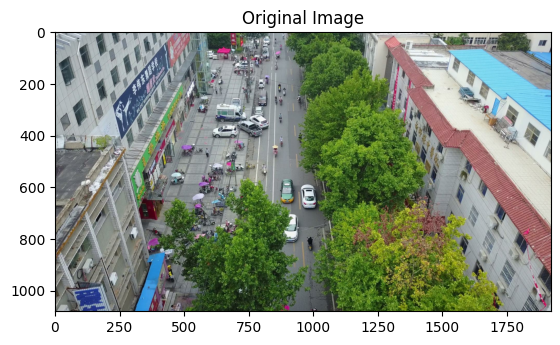

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    #img = tf.image.resize(img, [256, 256])  # Adjust size as needed
    return tf.cast(img, tf.float32) / 255.0

image = load_image(r"path")

plt.imshow(image.numpy())
plt.title("Original Image")
plt.show()

In [ ]:
class UnsupervisedSegmenter(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')
        self.edge_conv = tf.keras.layers.Conv2D(1, 3, padding='same')  
        
        self.segment_conv = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')  

    def call(self, inputs):
        x = self.conv1(inputs)
        edges = tf.sigmoid(self.edge_conv(x))  
        
        segments = self.segment_conv(tf.concat([inputs, edges], axis=-1))
        return edges, segments

model = UnsupervisedSegmenter()

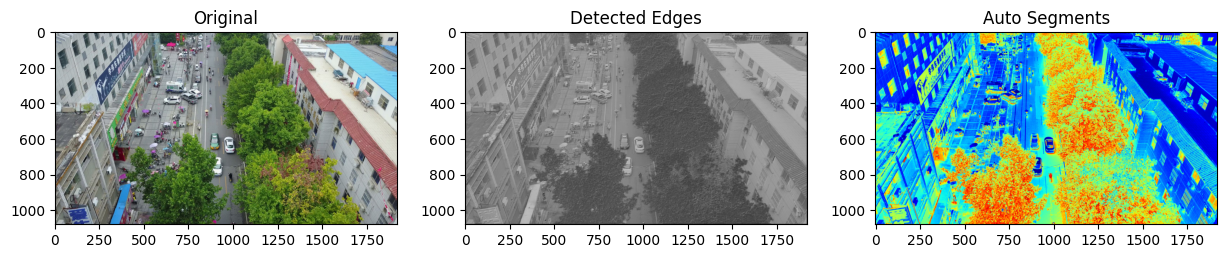

In [ ]:
edges, segments = model(tf.expand_dims(image, 0))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image.numpy())
plt.title("Original")

plt.subplot(1, 3, 2)
plt.imshow(edges.numpy().squeeze(), cmap='gray')
plt.title("Detected Edges")

plt.subplot(1, 3, 3)
plt.imshow(segments.numpy().squeeze(), cmap='jet')
plt.title("Auto Segments")
plt.show()

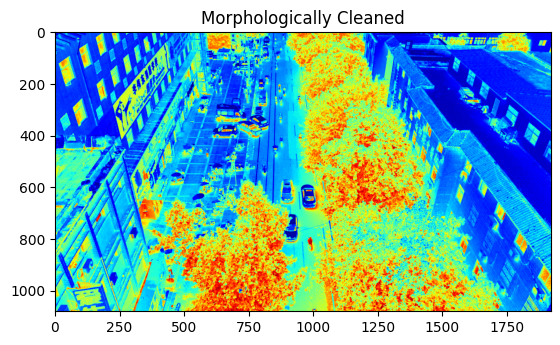

In [ ]:
def refine_morphological(segments, min_area=50):
    import cv2
    seg_np = (segments.numpy().squeeze() * 255).astype(np.uint8)
    
    kernel = np.ones((3,3), np.uint8)
    cleaned = cv2.morphologyEx(seg_np, cv2.MORPH_OPEN, kernel, iterations=1)
    
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        if cv2.contourArea(cnt) < min_area:
            cv2.drawContours(cleaned, [cnt], 0, 0, -1)
    
    return cleaned / 255.0

refined = refine_morphological(segments)
plt.imshow(refined, cmap='jet')
plt.title("Morphologically Cleaned")
plt.show()